In [2]:
#### https://www.kaggle.com/dikshabhati2002/let-s-classify-audio-ml-dl

import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display as ipd
from scipy.io import wavfile as wav
import pandas as pd
import math
import os
import numpy as np
import seaborn as sns
import json

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras

import tensorflow.keras as keras
from tensorflow.keras import optimizers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *

In [3]:
sample_rate = 22050
sr = 22050     # sample rate. based on Nyquist frequency, we only care about frequencies up to 10kHz therefor the sample rate will only perserve those frequencies 
n_fft = 2048
hop_length = 512
duration = 30 # length of song to be used (in seconds) 
n_mels=128
samples_per_track = sr * duration
n_mfcc = 40

json_path = r"data.rec.json"

In [4]:
# set a path pointing to folder with data
filepath = '/Users/stephen/Flatiron/Phase4/MIR/Data/genres_original'
# folders contain different genres (classes), lets list all the genres
print(list(os.listdir(f'{filepath}/')))

['pop', '.DS_Store', 'metal', 'disco', 'blues', 'reggae', 'classical', 'rock', '.gitattributes', 'hiphop', 'country', 'jazz']


In [5]:
def save_rec_matrix(dataset_path, json_path, n_mfcc=n_mfcc, n_fft=n_fft,
             hop_length=hop_length, num_segments=5):
    # Data storage dictionary
    data = {
        "mapping": [],
        "rec_matrix": [],
        "labels": [],
    }
    samples_ps = int(samples_per_track/num_segments) # ps = per segment
    expected_vects_ps = math.ceil(samples_ps/hop_length)
    
    # loop through all the genres
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        # ensuring not at root
        if dirpath is not dataset_path:
            # save the semantic label
            dirpath_comp = dirpath.split("/")
            semantic_label = dirpath_comp[-1]
            data["mapping"].append(semantic_label)
            print(f"Processing: {semantic_label}")
            
            # process files for specific genre
            for f in filenames:
                if(f==str("jazz.00054.wav")):
                    # As librosa only read files <1Mb
                    continue
                else:
                    # load audio file
                    file_path = os.path.join(dirpath, f)
                    signal,sr = librosa.load(file_path,sr=sample_rate)
                    for s in range(num_segments):
                        start_sample = samples_ps * s
                        finish_sample = start_sample + samples_ps

                        chroma = librosa.feature.chroma_cqt(signal[start_sample:finish_sample],
                                                    sr = sr,
                                                    hop_length = hop_length)
                        chroma_stack = librosa.feature.stack_memory(chroma, n_steps=10, delay=3)
                        R = librosa.segment.recurrence_matrix(chroma_stack)


                        R = R.T

                        # store mfcc if it has expected length 
                        if len(R)==expected_vects_ps:
                            data["rec_matrix"].append(R.tolist())
                            data["labels"].append(i-1)
                            #print(f"{file_path}, segment: {s+1}")

    with open(json_path,"w") as f:
        json.dump(data,f,indent=4)
     

In [6]:
save_rec_matrix(filepath,json_path,num_segments=10)
#clear_output()

Processing: pop
Processing: metal
Processing: disco
Processing: blues
Processing: reggae
Processing: classical
Processing: rock
Processing: hiphop


/Users/stephen/opt/anaconda3/envs/torch_env/lib/python3.9/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=1024 is too small for input signal of length=1011
  warnings.warn(


Processing: country
Processing: jazz


In [7]:
# loading in the data 
def load_data(filepath):
    with open(filepath, 'r') as f:
        data = json.load(f)

    # convert list to numpy arrays
    inputs = np.array(data["rec_matrix"])
    targets = np.array(data['labels'])

    return inputs, targets 

In [8]:
# set up variables 
inputs, targets = load_data(r'/Users/stephen/Flatiron/Phase4/MIR/notebooks/stephen/data.rec.json')
inputs.shape

(9986, 130, 130)

In [9]:
# splitting the data 
# input_train, input_test, target_train, target_test
X_train, X_test, y_train, y_test = train_test_split(inputs, targets, test_size=0.3)
print(X_train.shape, y_train.shape)

(6990, 130, 130) (6990,)


In [10]:
# CNN

def prepare_dataset(test_size, validation_size):
    X,y = load_data(r"/Users/stephen/Flatiron/Phase4/MIR/notebooks/stephen/data.rec.json")
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = validation_size)
    X_train = X_train[..., np.newaxis]
    X_val = X_val[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_val, X_test, y_train, y_val, y_test

In [11]:
X_train, X_val, X_test, y_train, y_val, y_test = prepare_dataset(0.25, 0.2)

In [12]:
input_shape = (X_train.shape[1],X_train.shape[2],X_train.shape[3])
print(input_shape)

(130, 130, 1)


In [13]:
model = Sequential()
model.add(Conv2D(64, (3, 3), activation = "relu", input_shape = input_shape))
model.add(MaxPool2D((3, 3), strides=(2, 2), padding="same"))
model.add(BatchNormalization())

model.add(Conv2D(32, (3, 3), activation = "relu"))
model.add(MaxPool2D((3, 3), strides=(2, 2), padding="same"))
model.add(BatchNormalization())

model.add(Conv2D(32, (2, 2), activation = "relu"))
model.add(MaxPool2D((2, 2), strides=(2, 2), padding="same"))
model.add(BatchNormalization())

model.add(Conv2D(16, (1, 1), activation = "relu"))
model.add(MaxPool2D((1, 1), strides=(2, 2), padding="same"))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(10, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                        

2021-11-18 22:17:02.160268: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
adam = optimizers.Adam(learning_rate=1e-4)

In [15]:
model.compile(optimizer=adam,
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

hist = model.fit(X_train, y_train,
                 validation_data = (X_val, y_val),
                 epochs = 40,
                 batch_size = 32)


Epoch 1/40
188/188 [==============================] - 83s 440ms/step - loss: 2.5326 - accuracy: 0.1153 - val_loss: 2.3996 - val_accuracy: 0.0908
Epoch 2/40
188/188 [==============================] - 84s 449ms/step - loss: 2.2823 - accuracy: 0.1466 - val_loss: 2.4328 - val_accuracy: 0.0915
Epoch 3/40
188/188 [==============================] - 82s 435ms/step - loss: 2.2198 - accuracy: 0.1698 - val_loss: 2.2770 - val_accuracy: 0.1475
Epoch 4/40
188/188 [==============================] - 83s 439ms/step - loss: 2.1740 - accuracy: 0.1988 - val_loss: 2.1974 - val_accuracy: 0.1983
Epoch 5/40
188/188 [==============================] - 83s 440ms/step - loss: 2.1313 - accuracy: 0.2173 - val_loss: 2.1840 - val_accuracy: 0.2096
Epoch 6/40
188/188 [==============================] - 80s 423ms/step - loss: 2.0850 - accuracy: 0.2399 - val_loss: 2.1713 - val_accuracy: 0.2196
Epoch 7/40
188/188 [==============================] - 77s 412ms/step - loss: 2.0413 - accuracy: 0.2604 - val_loss: 2.1557 - val_ac

In [16]:
def plot_history(hist):
    plt.figure(figsize=(20,15))
    fig, axs = plt.subplots(2)
    # accuracy subplot
    axs[0].plot(hist.history["accuracy"], label="train accuracy")
    axs[0].plot(hist.history["val_accuracy"], label="test accuracy")    
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")
    
    # Error subplot
    axs[1].plot(hist.history["loss"], label="train error")
    axs[1].plot(hist.history["val_loss"], label="test error")    
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")
    
    plt.show()

<Figure size 1440x1080 with 0 Axes>

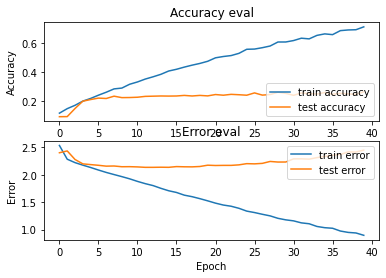

In [17]:
plot_history(hist)

In [18]:
test_error, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test accuracy: {test_accuracy}")

79/79 [==============================] - 9s 112ms/step - loss: 2.4363 - accuracy: 0.2571
Test accuracy: 0.25710853934288025


In [19]:
def predict(model, X, y):
    X = X[np.newaxis,...]
    prediction = model.predict(X)
    predicted_index = np.argmax(prediction, axis=1)
    print(f"Expected index: {y}, Predicted index: {predicted_index}")

In [20]:
predict(model, X_test[10], y_test[10])

Expected index: 2, Predicted index: [2]
